In [1]:
import pandas as pd
import requests
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

url = 'https://raw.githubusercontent.com/KasperLoos/ConsultElement/main/data/bronze_data/startup_failures.csv'
response = requests.get(url)

# Save the content of the file
with open('startup_failures.csv', 'wb') as file:
    file.write(response.content)

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('startup_failures.csv')

In [2]:
df

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,NaN,1,NaN,2014-01-30,2014-01-30
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
4,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01,2014-07-24,2014-07-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66363,/organization/zznode-science-and-technology-co...,ZZNode Science and Technology,http://www.zznode.com,Enterprise Software,1587301,operating,CHN,22,Beijing,Beijing,1,NaN,2012-04-01,2012-04-01
66364,/organization/zzzzapp-com,Zzzzapp Wireless ltd.,http://www.zzzzapp.com,Advertising|Mobile|Web Development|Wireless,114304,operating,HRV,15,Split,Split,4,2012-05-13,2011-11-01,2014-03-01
66365,/organization/Áeron,ÁERON,http://www.aeron.hu/,NaN,-,operating,NaN,NaN,NaN,NaN,1,2011-01-01,2014-08-01,2014-08-01
66366,/organization/Ôasys-2,Ôasys,http://www.oasys.io/,Consumer Electronics|Internet of Things|Teleco...,18192,operating,USA,CA,SF Bay Area,San Francisco,1,2014-01-01,2015-01-01,2015-01-01


In [3]:
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'].replace({'$': '', ',': ''}, regex=True), errors='coerce')
df['funding_total_mean_imputed'] = df['funding_total_usd']

In [4]:
#if founded is missing, we take first funding
#if first funding is missing, we take founding
#if last funding is missing, we take first funding
df['founded_at'] = df['founded_at'].fillna(df['first_funding_at'])
df['first_funding_at'] = df['first_funding_at'].fillna(df['founded_at'])
df['last_funding_at'] = df['last_funding_at'].fillna(df['first_funding_at'])
#if still missing, we take last funding
df['founded_at'] = df['founded_at'].fillna(df['last_funding_at'])
df['first_funding_at'] = df['first_funding_at'].fillna(df['last_funding_at'])
missing_counts = df[['founded_at', 'first_funding_at', 'last_funding_at']].isna().sum()
print(missing_counts)

# Calculate the time difference between 'founded_at' and 'first_funding_at'
df['time_before_first_funding'] = df['first_funding_at'] - df['founded_at']
# Calculate the time difference between 'first_funding_at' and 'last_funding_at'
df['time_between_first_last_funding'] = df['last_funding_at'] - df['first_funding_at']

#get month and year info from dates
df['founded_year'] = df['founded_at'].dt.year
df['founded_month'] = df['founded_at'].dt.month
df['funding_year'] = df['first_funding_at'].dt.year
df['funding_month'] = df['first_funding_at'].dt.month


founded_at          0
first_funding_at    0
last_funding_at     0
dtype: int64


In [5]:
df['failed'] = df['status'].apply(lambda x: 1 if x == 'closed' else 0)
df['has_website'] = df['homepage_url'].apply(lambda x: 1 if pd.notna(x) and x.strip() != '' else 0)


In [6]:
import re


def clean_category(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = text.replace('|', ' ')  # Replace '|' with space
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove punctuation/symbols
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    return text

df['category_list_cleaned'] = df['category_list'].apply(clean_category)
df[['category_list', 'category_list_cleaned']].head(10)

,category_list,category_list_cleaned
0,Media,media
1,Application Platforms|Real Time|Social Network...,application platforms real time social network...
2,Apps|Games|Mobile,apps games mobile
3,Curated Web,curated web
4,Software,software
5,Games,games
6,Biotechnology,biotechnology
7,Analytics,analytics
8,Mobile,mobile
9,E-Commerce,ecommerce


In [7]:
unique_categories_clean = df['category_list_cleaned'].dropna().unique()
print(unique_categories_clean.shape)

(27273,)


In [8]:
all_words = [word for cat in unique_categories_clean for word in cat.split()]
all_words
# Get unique words
unique_words = sorted(set(all_words))  # sorted is optional

# Join into a single space-separated string
unique_words_string = ' '.join(unique_words)

print(unique_words_string)
# Length of unique words list
unique_words_length = len(unique_words)

print(f"Number of unique words: {unique_words_length}")

20 3d 7 accessories accounting active activists ad adaptive adherence adults advanced adventure advertising advice aerospace africa agent agriculture aid air algorithms all alternative alumni analytics and android angels animal anything apis app application applications apps aquaculture architecture archiving art artificial artists arts asia assessment asset assisitive assisted auctions audio audiobooks augmented auto automated automation automotive b2b babies baby banking based batteries beauty beer behavior benefits bicycles bid big billing biofuels bioinformatics biomass biometrics biopharm biotechnology bitcoin blogging boating bookmarking boomers bpo brand branding breakthrough brewing bridging broadcasting broker brokers browser browsers builders building business businesses buying cable cad call campuses cannabis capital capture carbon card cards care career cars casual cause celebrity cells center centers certification chain charities charity charter chat chemicals child childr

In [9]:
# Define categories and the associated keywords
categories = {
    'Legal': ['legal', 'licensing', 'law'],
    'Marketing & PR': ['marketing', 'advertisements', 'advertising', 'public relations'],
    'dating & adult': ['dating', 'matchmaking', 'wedding', 'sex', 'adult', 'gay', 'lesbian'],
    'art & creative': ['art', 'photography', 'video', 'design', 'graphics', 'creative', 'film'],
    'Entertainment': ['lotteries', 'gambling','nightclubs', 'nightlife', 'sporting', 'sports', 'music', 'movies', 'games', 'game', 'gamification', 'gaming', 'sports', 'comics', 'entertainment', 'tv', 'ebooks', 'books', 'audiobooks', 'publishing'],
    'Healthcare and wellness': ['clinical','care','dental','wellness','medicine', 'healthcare', 'hospitals', 'doctors', 'medication', 'pharmaceuticals', 'pharmacies', 'health', 'emergencyhealth', 'medical'],
    'Finance & Business': ['financial','fraud','accounting', 'investment ', 'insurance','payments', 'finance', 'banking', 'investing', 'capital', 'business', 'entrepreneurship', 'economy', 'venture', 'ventures'],
    'Retail & E-commerce': ['shopping', 'products', 'retail', 'stores', 'marketplaces', 'ecommerce', 'sales'],
    '(Social) Media & Communication': ['journalism','broadcasting', 'content', 'news', 'social', 'messaging', 'newsletters', 'polling', 'chat', 'communication', 'sms', 'blogging', 'email', 'media', 'telecommunications', 'telephony'],
    'Education': ['education', 'learning', 'school', 'schools', 'universities', 'courses', 'teachers', 'tutorials', 'students', 'alumni'],
    'Energy & Environment': ['biofuels', 'energy', 'solar', 'wind', 'green', 'sustainability', 'renewable', 'clean', 'environmental', 'oil', 'gas'],
    'Lifestyle & Consumer Goods': ['lingerie', 'shoes','jewelry', 'wearables','fashion', 'fitness', 'lifestyle', 'leisure', 'beauty', 'home', 'food', 'luxury', 'gadgets', 'cosmetics', 'furniture'],
    'Transport': ['taxis','distribution','mobility','parking','bicycles', 'boating','shipping','distribution','delivery', 'automotive', 'cars', 'vehicles', 'transportation', 'driving', 'motors', 'navigation', 'limousines'],
    'Science & Research': ['science', 'research', 'biometrics', 'neuroscience', 'genetic','biopharm', 'biology', 'chemistry', 'physics', 'engineering'],
    'Data': ['analytics', 'data', 'databases'],
    'Animal': ['veterinary', 'pets', 'pet', 'animal', 'animals'],
    'Hospitality': ['hospitality', 'restaurants'],
    'Crypto' : ['bitcoin', 'fintech', 'cryptocurrency'],
    '(3D) Printing': ['printing', '3d'],
    'real estate': ['estate', 'realtors', 'realtor', 'housing'],
    'security': ['security', 'safety'],
    'tourism': ['travel', 'tourism', 'vacation', 'hotels'],
    'manufacturing & construction': ['manufacturing', 'construction'],
    'consulting': ['consulting'],
    'Chemical': ['chemicals'],
    'Charity & Non-profit': ['charity', 'non profit', 'nonprofits', 'nonprofit', 'charities'],
    'Children':['children', 'kids', 'baby', 'toys', 'toy', 'child', 'babies', 'parenting'],
    'HR': ['human', 'employment', 'recruiting', 'staffing', 'incubators', 'training'],
    'waste': ['waste', 'water purification'],
    'nutrition & cooking': ['nutrition','food', 'drinks', 'beer', 'wine', 'brewing', 'fruit', 'tea', 'coffee', 'recipes', 'cooking'],
    'agriculture': ['agriculture', 'farming', 'farm'],
    'Service Sector' : ['services', 'service'],
    'consumer': ['consumer'],
    'logistics': ['logistics'],
    'management': ['management'],
    'raw materials': ['extraction', 'gold', 'glass', 'resources', 'minerals'],
    'politics': ['politics', 'government', 'governments'],
    'Technology & internet': ['translation','online', 'drones','iphone', 'ios', 'algorithms', 'digital','algorithms ','image recognition', 'lighting','processing', 'transfer','sensors','maps','augmented reality', 'computer','linux','technologies','hardware','voip','wireless','electronics', 'electrical ', 'saas','semiconductors','aerospace', 'apps', 'robotics', 'twitter', 'application', 'mobile', 'virtual', 'android', 'api', 'applications', 'automation', 'big', 'cloud', 'computers', 'cybersecurity', 'data', 'iot', 'machine', 'networking', 'software', 'web', 'internet', 'technology'],
    'search': ['search']
}

def categorize(row):
    for category, keywords in categories.items():
        if any(keyword in row for keyword in keywords):
            return category
    return 'Other'  # Return 'Other' if no category matches

# Apply the categorization
df['sector'] = df['category_list_cleaned'].apply(categorize)


In [10]:
other = df[df['sector']=='Other']
print(other.shape)
other[other['category_list_cleaned'].str.strip() != ''][['name', 'category_list', 'category_list_cleaned', 'sector', 'failed']].head(100)

(3540, 25)


,name,category_list,category_list_cleaned,sector,failed
388,4th Office,Office Space,office space,Other,0
1919,AgentRave,Reviews and Recommendations,reviews and recommendations,Other,1
2046,AHA Taxis,Tracking,tracking,Other,0
2561,Alliance Medical Corporation,Industrial|Mechanical Solutions,industrial mechanical solutions,Other,0
3058,Amp Your Good,Crowdfunding,crowdfunding,Other,0
3284,AngelVest,Angels,angels,Other,0
3427,Hornetsecurity,Local,local,Other,0
3862,AppSheet,Developer Tools,developer tools,Other,0
4006,Aquaminerals Finland Oy,Water,water,Other,0
4155,Arcturus Therapeutics Inc.,Therapeutics,therapeutics,Other,0


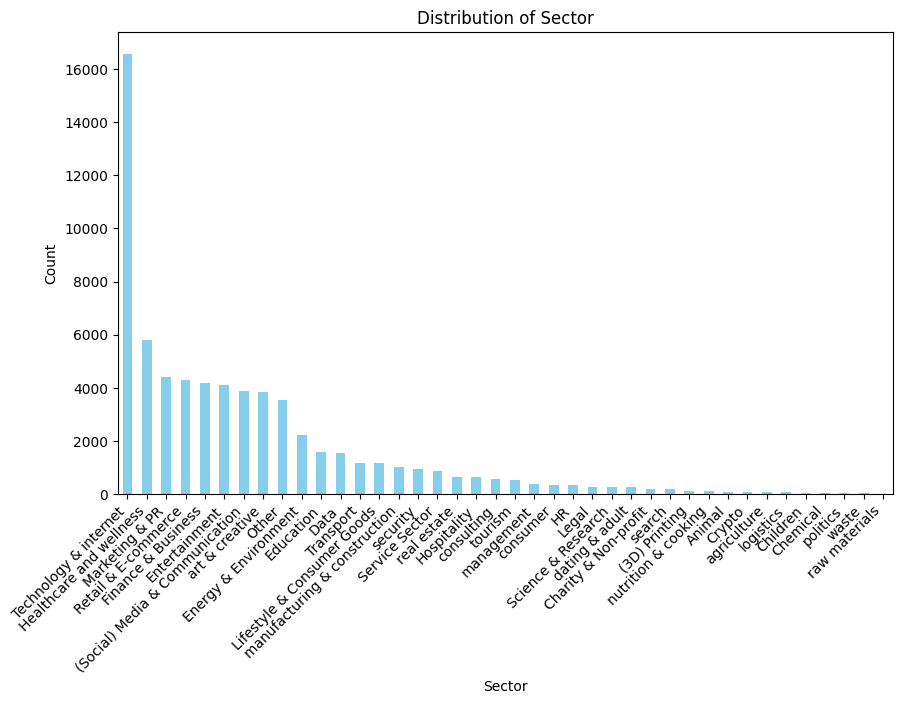

In [11]:
# Get the distribution of 'sector' column
sector_distribution = df['sector'].value_counts()
import matplotlib.pyplot as plt

# Plot the distribution
sector_distribution.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Distribution of Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [12]:
#SPLIT INTO TRAIN AND TEST
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)


In [13]:
# TRAIN
#Windsorization of funding_total_usd 	
lower_bound = df_train['funding_total_usd'].quantile(0.01)
upper_bound = df_train['funding_total_usd'].quantile(0.99)

missing = df_test['funding_total_usd'].isna().sum()
print({'missing values before': missing})

# Apply winsorization
df_train['funding_total_usd'] = df['funding_total_usd'].clip(lower=lower_bound, upper=upper_bound)
df_test['funding_total_usd'] = df['funding_total_usd'].clip(lower=lower_bound, upper=upper_bound)

summary = df_train['funding_total_usd'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
missing = df_test['funding_total_usd'].isna().sum()

print("Summary statistics for 'funding_total_usd':")
print(summary)
print(f"\nMissing values after: {missing}")

{'missing values before': np.int64(2610)}
Summary statistics for 'funding_total_usd':
count    4.291900e+04
mean     1.356125e+07
std      3.285798e+07
min      1.000000e+04
1%       1.000000e+04
5%       2.510700e+04
25%      3.298385e+05
50%      2.000000e+06
75%      1.000000e+07
95%      6.900000e+07
99%      2.246959e+08
max      2.248329e+08
Name: funding_total_usd, dtype: float64

Missing values after: 2610


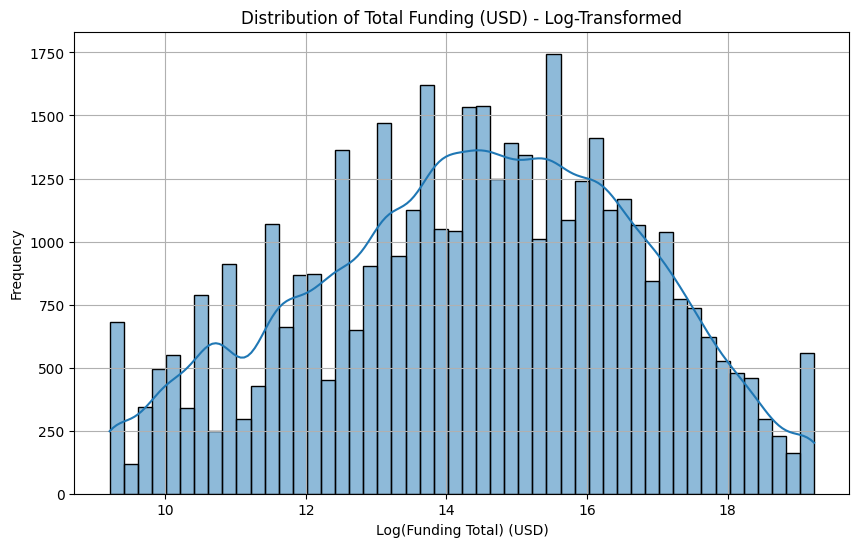

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Drop NaN values before plotting
data = df_train['funding_total_usd'].dropna()

# Optional: Remove extreme outliers (beyond 99th percentile)

# Log transform to handle skewness
data_log = data.apply(lambda x: np.log(x) if x > 0 else 0)

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data_log, bins=50, kde=True)
plt.title('Distribution of Total Funding (USD) - Log-Transformed')
plt.xlabel('Log(Funding Total) (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

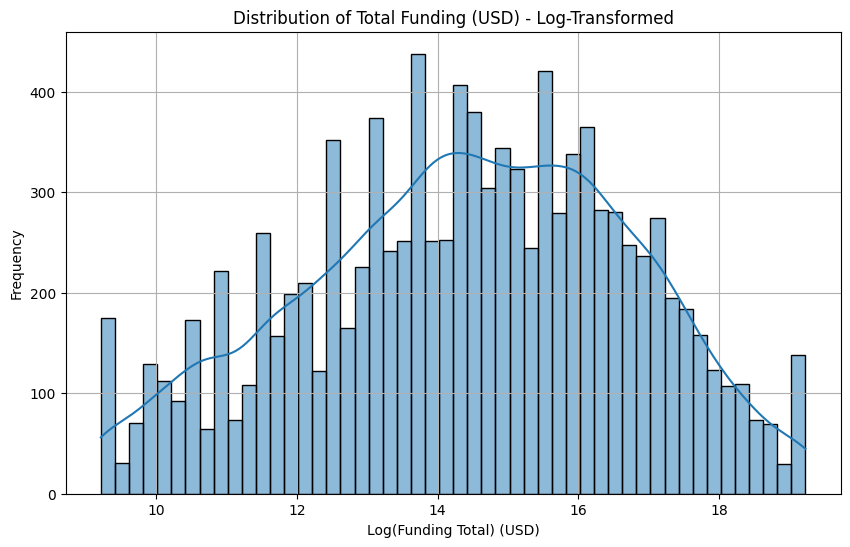

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Drop NaN values before plotting
data = df_test['funding_total_usd'].dropna()

# Optional: Remove extreme outliers (beyond 99th percentile)

# Log transform to handle skewness
data_log = data.apply(lambda x: np.log(x) if x > 0 else 0)

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data_log, bins=50, kde=True)
plt.title('Distribution of Total Funding (USD) - Log-Transformed')
plt.xlabel('Log(Funding Total) (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

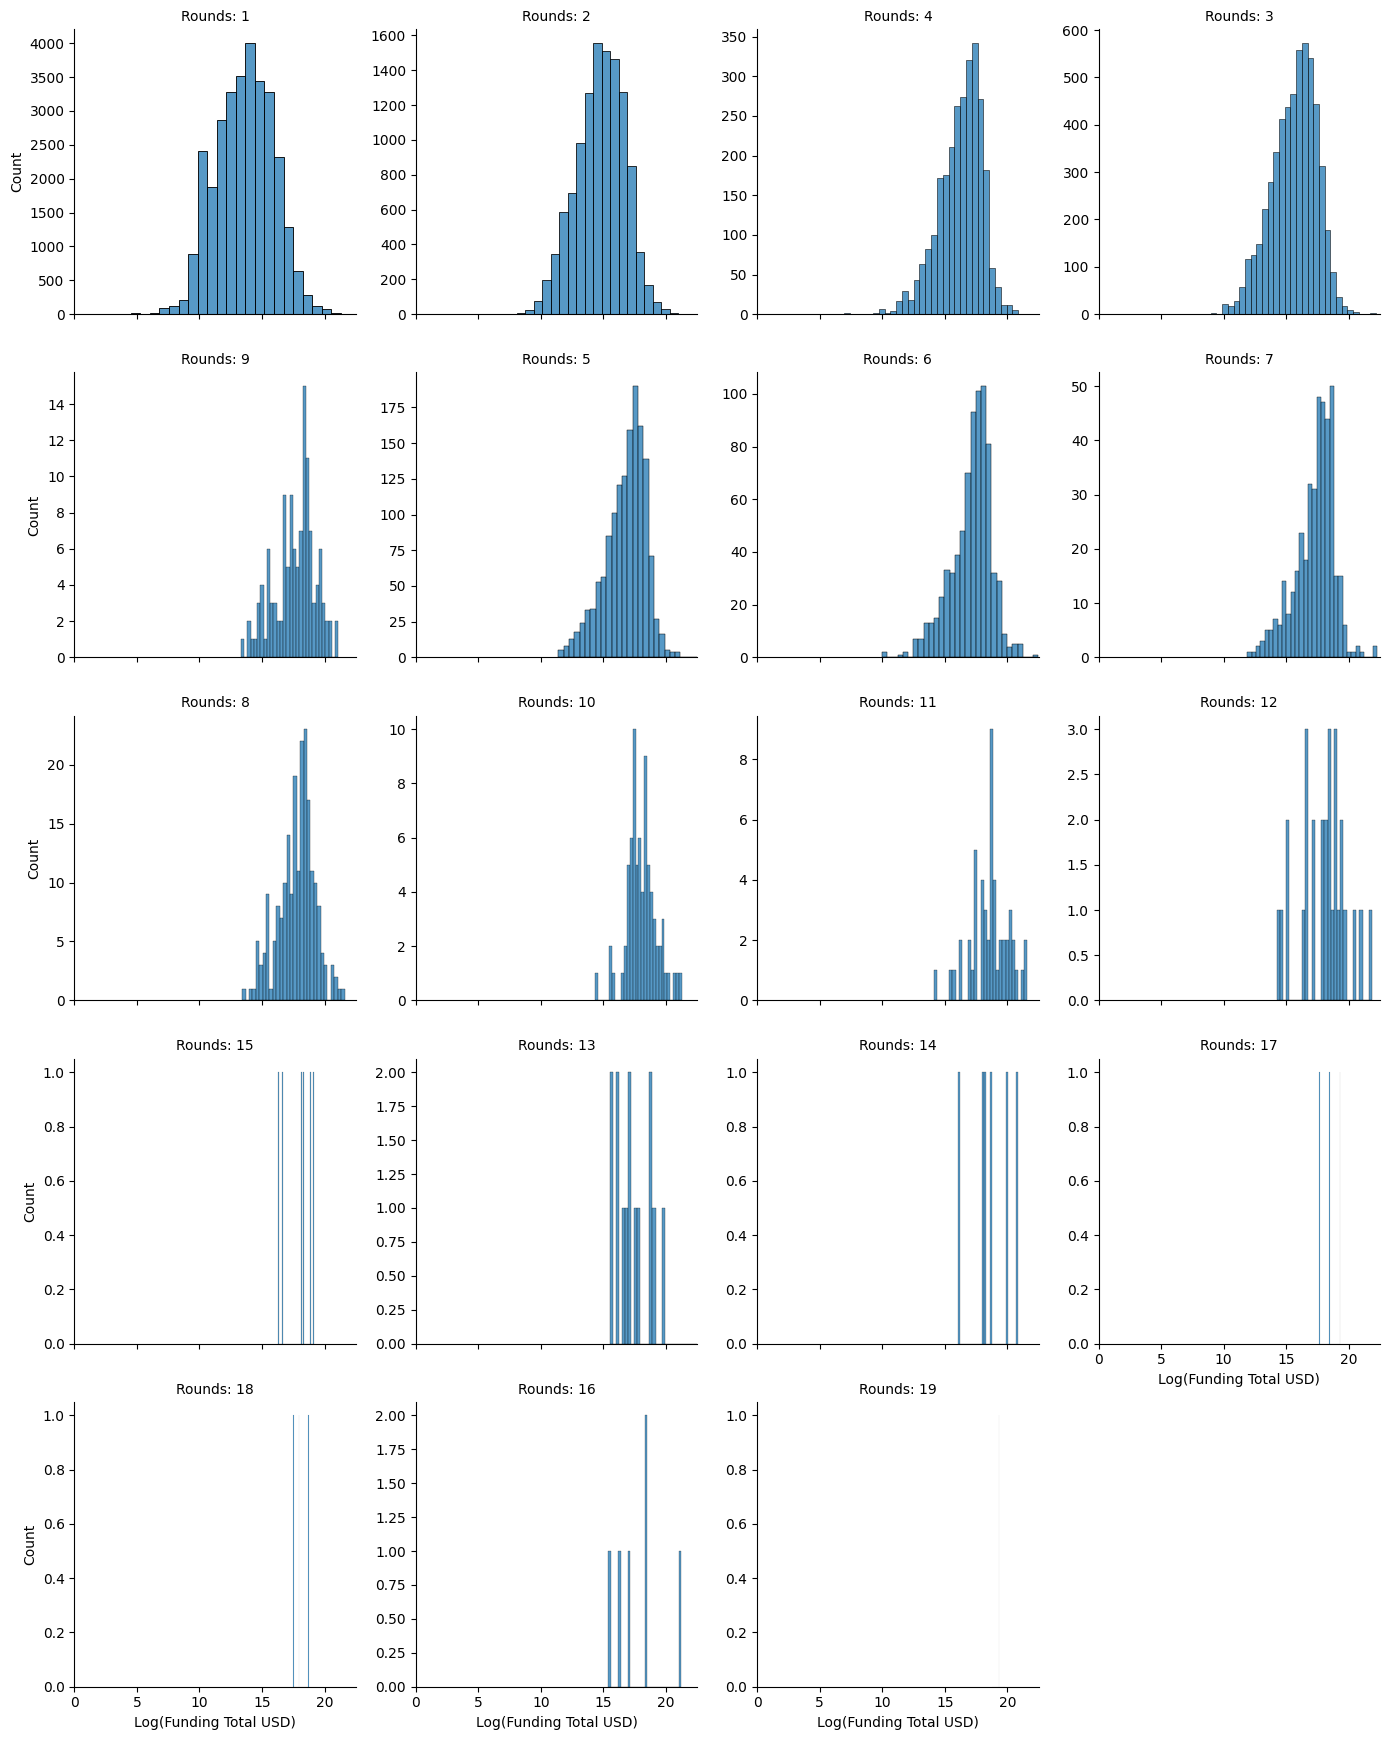

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
df_plot = df.copy()
df_plot['funding_total_usd_log'] = np.log1p(df_plot['funding_total_usd'])

# Handle missing values in funding_rounds
df_plot['funding_rounds_str'] = df_plot['funding_rounds'].astype('Int64').astype(str)
df_plot.loc[df['funding_rounds'].isna(), 'funding_rounds_str'] = 'Missing'

# Plot: shared x-axis, independent y-axis
g = sns.FacetGrid(
    df_plot,
    col='funding_rounds_str',
    col_wrap=4,
    sharex=True,     # all plots have same x-axis
    sharey=False,    # allow different y-axis scales per group
    height=3.5
)
g.map_dataframe(sns.histplot, x='funding_total_usd_log', bins=30)

# Set fixed x-axis range for all facets
g.set(xlim=(0, 22.5))
g.set_axis_labels("Log(Funding Total USD)", "Count")
g.set_titles("Rounds: {col_name}")
plt.tight_layout()
plt.show()


## OPTION 1: KNN imputation
### 1/2: impute in train set

In [17]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


# Define columns
target = 'funding_total_usd'
predictor_cols = ['country_code', 'funding_rounds', 'founded_at', 'sector', 'has_website', 
                  'time_before_first_funding', 'founded_month', 'first_funding_at', 
                  'last_funding_at', 'funding_year', 'funding_month']

# Step 1: Prepare the data
df_copy = df_train[[target] + predictor_cols].copy()

# Convert dates to numeric
date_cols = ['founded_at', 'first_funding_at', 'last_funding_at']
for col in date_cols:
    df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')
    df_copy[col] = df_copy[col].astype('int64') / (60*60*24*365.25)  # in years after 1970

# Handle timedelta if present
timedelta_cols = df_copy.select_dtypes(include='timedelta64[ns]').columns
for col in timedelta_cols:
    df_copy[col] = df_copy[col].dt.total_seconds()



In [18]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_copy, columns=df_copy.select_dtypes(include='object').columns, dummy_na=True)

# Step 2: Separate target from predictors
X_predictors = df_encoded.drop(columns=[target])
X_target = df_encoded[[target]]

# Step 3: Scale only predictors
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_predictors), columns=X_predictors.columns)

# Step 4: Concatenate unscaled target back
X_combined = pd.concat([X_target, X_scaled], axis=1)

# Impute all (target + predictors)
imputer = KNNImputer(n_neighbors=5)
X_imputed_full = pd.DataFrame(imputer.fit_transform(X_combined), columns=X_combined.columns)

# Update both funding_total_usd and predictors
df_train['funding_total_usd'] = X_imputed_full['funding_total_usd']

### 2/2: impute in test set

In [19]:
df_full = pd.concat([df_train, df_test])

In [20]:
# Step 1: Prepare the data
df_copy = df_full[[target] + predictor_cols].copy()

# Convert dates to numeric
date_cols = ['founded_at', 'first_funding_at', 'last_funding_at']
for col in date_cols:
    df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')
    df_copy[col] = df_copy[col].astype('int64') / (60*60*24*365.25)  # in years after 1970

# Handle timedelta if present
timedelta_cols = df_copy.select_dtypes(include='timedelta64[ns]').columns
for col in timedelta_cols:
    df_copy[col] = df_copy[col].dt.total_seconds()



In [21]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_copy, columns=df_copy.select_dtypes(include='object').columns, dummy_na=True)

# Step 2: Separate target from predictors
X_predictors = df_encoded.drop(columns=[target])
X_target = df_encoded[[target]]

# Step 3: Scale only predictors
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_predictors), columns=X_predictors.columns)

# Step 4: Concatenate unscaled target back
X_combined = pd.concat([X_target, X_scaled], axis=1)

# Impute all (target + predictors)
imputer = KNNImputer(n_neighbors=5)
X_imputed_full = pd.DataFrame(imputer.fit_transform(X_combined), columns=X_combined.columns)

# Update both funding_total_usd and predictors
df_full['funding_total_usd'] = X_imputed_full['funding_total_usd']

## OPTION 2
### 1/2: impute in train set

In [22]:
# First, create the group means
group_means = df_train.groupby('funding_rounds')['funding_total_mean_imputed'].mean()

# Then, define a function to apply to each row
def impute_funding(row):
    if pd.isna(row['funding_total_mean_imputed']):
        return group_means.get(row['funding_rounds'], np.nan)  # If no group mean, fallback to NaN
    else:
        return row['funding_total_mean_imputed']

# Apply the function to the dataframe
df_train['funding_total_mean_imputed'] = df.apply(impute_funding, axis=1)


### 2/2: impute in test set

In [23]:
# First, create the group means
group_means = df_full.groupby('funding_rounds')['funding_total_mean_imputed'].mean()

# Then, define a function to apply to each row
def impute_funding(row):
    if pd.isna(row['funding_total_mean_imputed']):
        return group_means.get(row['funding_rounds'], np.nan)  # If no group mean, fallback to NaN
    else:
        return row['funding_total_mean_imputed']

# Apply the function to the dataframe
df_full['funding_total_mean_imputed'] = df.apply(impute_funding, axis=1)

In [24]:
# Optional: Avoid divide-by-zero
df_full['average_funding'] = df_full['funding_total_usd'] / df_full['funding_rounds']
df_full

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,funding_total_mean_imputed,time_before_first_funding,time_between_first_last_funding,founded_year,founded_month,funding_year,funding_month,failed,has_website,category_list_cleaned,sector,average_funding
31069,/organization/kona-medical,Kona Medical,http://konamedical.com,Health Care|Medical|Therapeutics,2.850000e+05,operating,USA,WA,Seattle,Bellevue,7,2009-01-01,2010-05-03,2015-09-02,7.365769e+07,487 days,1948 days,2009,1,2010,5,0,1,health care medical therapeutics,Healthcare and wellness,4.071429e+04
42221,/organization/parabebes-com,paraBebes.com,http://www.parabebes.com,Babies|E-Commerce|Kids|Medical,3.800000e+07,operating,ESP,56,Barcelona,Barcelona,1,2005-01-01,2010-09-16,2010-09-16,2.615600e+05,2084 days,0 days,2005,1,2010,9,0,1,babies ecommerce kids medical,Healthcare and wellness,3.800000e+07
23839,/organization/grannus,Grannus,http://grannusllc.com/,Chemicals,1.645000e+06,operating,USA,AZ,Tucson,Tucson,1,2012-01-01,2015-04-21,2015-04-21,2.000000e+06,1206 days,0 days,2012,1,2015,4,0,1,chemicals,Chemical,1.645000e+06
60386,/organization/unconstrained-robotics,Unconstrained Robotics,NaN,Navigation|Robotics|Technology,1.457944e+08,closed,NaN,NaN,NaN,NaN,1,2015-06-30,2015-06-30,2015-06-30,1.667400e+04,0 days,0 days,2015,6,2015,6,1,0,navigation robotics technology,Transport,1.457944e+08
52388,/organization/smarkets,Smarkets,http://smarkets.com,Financial Exchanges|Gambling|Marketplaces|Sports,5.845685e+07,operating,GBR,H9,London,London,4,2008-01-01,2008-05-01,2013-02-21,2.710000e+06,121 days,1757 days,2008,1,2008,5,0,1,financial exchanges gambling marketplaces sports,Entertainment,1.461421e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32730,/organization/littlefeet-inc,Littlefeet Inc.,NaN,Services|Technology|Wireless,1.900000e+07,closed,NaN,NaN,NaN,NaN,1,2002-11-01,2002-11-01,2002-11-01,3.000000e+06,0 days,0 days,2002,11,2002,11,1,0,services technology wireless,Service Sector,1.900000e+07
21201,/organization/foodfan,FoodFan,http://www.foodfan.com,Delivery|Hospitality|Networking|Online Reserva...,1.000000e+05,operating,USA,NY,New York City,New York,1,2011-01-01,2012-01-01,2012-01-01,2.500000e+05,365 days,0 days,2011,1,2012,1,0,1,delivery hospitality networking online reserva...,(Social) Media & Communication,1.000000e+05
17049,/organization/eazycoach,EazyCoach,http://signup.eazycoach.com/,E-Commerce,2.750000e+06,operating,IND,28,Kolkata,Kolkata,1,2013-01-01,2015-08-26,2015-08-26,1.007059e+07,967 days,0 days,2013,1,2015,8,0,1,ecommerce,Retail & E-commerce,2.750000e+06
36464,/organization/mobileaware,MobileAware,http://www.mobileaware.com,Internet|Mobile|Software|Startups,2.240263e+08,operating,USA,MA,Boston,Boston,2,2000-01-01,2006-05-17,2008-08-11,6.960000e+06,2328 days,817 days,2000,1,2006,5,0,1,internet mobile software startups,art & creative,1.120132e+08


In [25]:
df_train, df_test = train_test_split(df_full, test_size=0.2, random_state=42)

In [26]:
df_train

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,funding_total_mean_imputed,time_before_first_funding,time_between_first_last_funding,founded_year,founded_month,funding_year,funding_month,failed,has_website,category_list_cleaned,sector,average_funding
50662,/organization/sentence-lab,Sentence Lab,http://www.clippick.com,Cloud Data Services|Internet|Technology,7.763553e+07,closed,KOR,13,KOR - Other,Dongan,3,2012-07-27,2012-01-01,2013-09-01,8.873100e+04,-208 days,609 days,2012,7,2012,1,1,1,cloud data services internet technology,Data,2.587851e+07
28469,/organization/interplay-entertainment,Interplay Entertainment,http://www.interplay.com,Entertainment|Games,1.200000e+05,ipo,USA,CA,Los Angeles,Beverly Hills,1,1982-01-01,2010-03-17,2010-03-17,9.800000e+05,10302 days,0 days,1982,1,2010,3,0,1,entertainment games,Entertainment,1.200000e+05
20100,/organization/fear-hunters,Fear Hunters,http://www.fearhunters.com,Education|Toys,2.800000e+04,operating,BEL,11,Brussels,Brussels,2,2008-09-01,2012-01-01,2014-01-20,4.938470e+05,1217 days,750 days,2008,9,2012,1,0,1,education toys,Education,1.400000e+04
19566,/organization/eyeglass24,EYEGLASS24,http://www.eyeglass24.de,E-Commerce,1.068060e+07,operating,DEU,2,Munich,Munich,1,2012-08-02,2013-09-01,2013-09-01,1.007059e+07,395 days,0 days,2012,8,2013,9,0,1,ecommerce,Retail & E-commerce,1.068060e+07
65863,/organization/zero-locus,Zero Locus,http://zerolocus.com,Software,1.205265e+08,operating,USA,WI,Milwaukee,Milwaukee,1,2013-01-04,2013-01-04,2013-01-04,2.000000e+04,0 days,0 days,2013,1,2013,1,0,1,software,Technology & internet,1.205265e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56628,/organization/tdi-bassline,TDI Bassline,http://www.tdibassline.com,E-Commerce,1.250000e+07,operating,USA,TX,Houston,Houston,1,2012-04-10,2014-08-24,2014-08-24,1.000000e+04,866 days,0 days,2012,4,2014,8,0,1,ecommerce,Retail & E-commerce,1.250000e+07
22815,/organization/getyourhero,GetYourHero,http://www.getyourhero.com,Internet,3.000000e+07,operating,ESP,56,Barcelona,Barcelona,2,2014-04-03,2014-10-01,2015-07-29,1.922323e+06,181 days,301 days,2014,4,2014,10,0,1,internet,Technology & internet,1.500000e+07
5657,/organization/backspaces,Backspaces,http://backspac.es,Photography,4.900000e+05,operating,USA,NY,New York City,New York,2,2012-01-01,2013-03-01,2013-10-24,1.625000e+05,425 days,237 days,2012,1,2013,3,0,1,photography,art & creative,2.450000e+05
52788,/organization/snowgate,SnowGate,http://www.snowgate.com,Security|Sports|Twin-Tip Skis,4.529509e+07,operating,USA,CO,Denver,Boulder,3,2012-02-01,2012-06-05,2013-12-31,1.060000e+06,125 days,574 days,2012,2,2012,6,0,1,security sports twintip skis,Entertainment,1.509836e+07


In [27]:
df_test

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,funding_total_mean_imputed,time_before_first_funding,time_between_first_last_funding,founded_year,founded_month,funding_year,funding_month,failed,has_website,category_list_cleaned,sector,average_funding
40869,/organization/onesource-water,OneSource Water,http://onesourcewater.net,Curated Web,6.224770e+05,operating,USA,CT,Hartford,Farmington,1,2004-01-01,2014-04-06,2014-04-06,5.125000e+06,3748 days,0 days,2004,1,2014,4,0,1,curated web,Technology & internet,6.224770e+05
25650,/organization/hive7,Hive7,http://hive7.com,Entertainment|Facebook Applications|Games|Inte...,2.000000e+06,acquired,USA,CA,SF Bay Area,Palo Alto,1,2006-06-01,2006-01-01,2006-01-01,1.007059e+07,-151 days,0 days,2006,6,2006,1,0,1,entertainment facebook applications games inte...,Entertainment,2.000000e+06
61928,/organization/viewceler,Viewceler,NaN,Business Productivity|Productivity Software|So...,3.600000e+07,closed,USA,CA,SF Bay Area,Palo Alto,1,2002-01-01,2002-11-19,2002-11-19,6.500000e+06,322 days,0 days,2002,1,2002,11,1,0,business productivity productivity software so...,Finance & Business,3.600000e+07
32892,/organization/loadcomplete,Loadcomplete,http://www.loadcomplete.com,Games,4.165017e+06,operating,KOR,NaN,NaN,NaN,2,2009-12-11,2012-12-10,2014-05-09,1.058197e+06,1095 days,515 days,2009,12,2012,12,0,1,games,Entertainment,2.082508e+06
34423,/organization/mashworx,MashWorx,http://www.mashworx.com,NaN,1.624235e+07,operating,USA,UT,Salt Lake City,Orem,1,2010-01-01,2010-09-03,2010-09-03,1.007059e+07,245 days,0 days,2010,1,2010,9,0,1,,Other,1.624235e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22343,/organization/gc-rise-pharmaceutical,GC-Rise Pharmaceutical,http://gc-rise.com/english/,Health Care|Medical Devices|Pharmaceuticals,1.865707e+08,operating,CHN,19,CHN - Other,Chaoyang,1,2008-01-01,2014-09-02,2014-09-02,1.500000e+07,2436 days,0 days,2008,1,2014,9,0,1,health care medical devices pharmaceuticals,Healthcare and wellness,1.865707e+08
40568,/organization/olson-networks,Olson Networks,http://olsonnetworks.webs.com/,Enterprises,1.878300e+04,operating,USA,TX,Houston,Houston,1,2013-10-22,2013-10-22,2013-10-22,1.000000e+03,0 days,0 days,2013,10,2013,10,0,1,enterprises,Other,1.878300e+04
24516,/organization/gyan-lab,GyanLab,http://www.gyanlab.com,Analytics|EdTech|K-12 Education|Parenting,5.222288e+06,operating,IND,19,Bangalore,Bangalore,1,2011-01-20,2015-03-31,2015-03-31,1.007059e+07,1531 days,0 days,2011,1,2015,3,0,1,analytics edtech k12 education parenting,Education,5.222288e+06
19455,/organization/explain-my-surgery,Explain My Surgery,http://explainmysurgery.com,Biotechnology,2.525000e+07,operating,USA,NV,Las Vegas,Las Vegas,1,2008-11-19,2008-11-19,2008-11-19,9.720000e+05,0 days,0 days,2008,11,2008,11,0,1,biotechnology,Technology & internet,2.525000e+07


In [29]:
df_train.to_csv('train_cleaned.csv', index=False)
df_test.to_csv('test_cleaned.csv', index=False)

In [ ]:
df

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
import numpy as np

# Custom penalty score
def custom_loss(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    fn = np.sum((y_true == 1) & (y_pred == 0))  # Missed failures
    fp = np.sum((y_true == 0) & (y_pred == 1))  # Incorrect failure predictions

    loss = 100 * fn + 1 * fp
    return -loss  #We return negative loss because GridSearchCV *maximizes* the score

# Wrap it in a scorer
custom_scorer = make_scorer(custom_loss, greater_is_better=False)


# Define the features (X) and the target (y)
X = df[['sector', 'funding_total_usd', 'country_code', 'state_code', 'region', 'city', 
        'funding_rounds', 'time_before_first_funding', 'time_between_first_last_funding', 
        'founded_year', 'founded_month', 'funding_year', 'funding_month', 'average_funding', 
        'has_website']]
y = df['failed']


# Define categorical columns
categorical_columns = ['sector', 'country_code', 'state_code', 'region', 'city']

# Create the column transformer for one-hot encoding
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ],
    remainder='passthrough'  # Keeps the rest of the columns (like numeric ones)
)

X_encoded = column_transformer.fit_transform(X)
feature_names = column_transformer.named_transformers_['onehot'].get_feature_names_out(categorical_columns)

# Convert to DataFrame (if needed)
import pandas as pd
X = pd.DataFrame(X_encoded, columns=list(feature_names) + list(X.drop(columns=categorical_columns).columns))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_grid = {
    'max_depth': [6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'scale_pos_weight': [(len(y) - sum(y)) / sum(y)]  # class imbalance
}


grid_search = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='logloss'),
                           param_grid=param_grid,
                           cv=3,
                           scoring=custom_scorer,
                           verbose=1)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Train the model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predict
y_pred = best_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
loss = custom_loss(y_test, y_pred)
print(f"Custom penalty loss: {-loss}")

In [ ]:
# Get predicted probabilities for the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability for the 'failed' class (class 1)

# Adjust the threshold for predicting 'failed=1'
y_pred_adjusted = (y_pred_prob > 0.2).astype(int)

# Evaluate the model using the adjusted predictions
print("Classification Report (with adjusted threshold):")
print(classification_report(y_test, y_pred_adjusted))

In [ ]:
importance = model.feature_importances_

# Map to column names
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model, max_num_features=10, importance_type='cover')  # 'weight', 'gain', 'cover'
plt.show()
